<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/Without%20Purcell%20Filter%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [ ]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 16.0 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit, minimize

In [ ]:
photon_list = np.array([0.0027809028825555213,
 0.0026145547910848515,
 0.0025759084899649558,
 0.0025300857393330913,
 0.0024721860424756076,
 0.002404658267884932,
 0.00232972434542873,
 0.002249191702467065,
 0.00216471175819369,
 0.0020777731073821333,
 0.0019896909924748828,
 0.001901601683921792,
 0.0018144559523372242,
 0.001729025223704284,
 0.0016459137710553046,
 0.0015655757637011499,
 0.0014883345171498746,
 0.0014144023272667757,
 0.0013438996421100558,
 0.0012768726076316098,
 0.0012133087588619728,
 0.001153150513574239,
 0.0010963065902604232,
 0.0010426615050069129,
 0.0009920831410228194,
 0.0009444290470273011,
 0.000899551184805238,
 0.0008572996458893036,
 0.0008175255168309781,
 0.0007800829247872276,
 0.0007448305681687934,
 0.0007116327390442251,
 0.000680359979521634,
 0.0006508894828826867,
 0.0006231052531051273,
 0.0005968981150239936,
 0.0005721656211988016,
 0.0005488118416939651,
 0.0005267470971361585,
 0.0005058877649865623,
 0.00048615582562322506,
 0.0004674786384050148,
 0.0004497885858590055,
 0.00043302276556545405,
 0.00041712266737155734,
 0.0004020336565742253,
 0.00038770559364585124,
 0.0003740911892611879,
 0.0003611466717131576,
 0.00034883132158072583])

Text(0, 0.5, 'Average Photon Number')

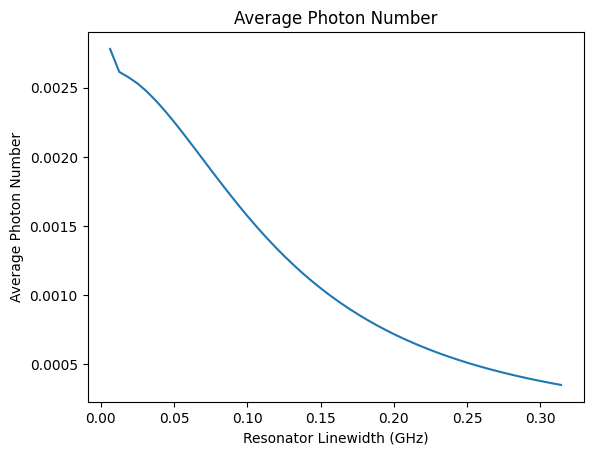

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, photon_list)

plt.title('Average Photon Number')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Average Photon Number')

# CP CPMG UDD XY4 XY8 XY16 Sequence

In [ ]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


def Pulse_Timing_1(T_srt, T_end, N, kappa):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [ ]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [ ]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [ ]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [ ]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame_1(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [ ]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [ ]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Sequence Optimization

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 400
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 5. 15. 25. 35.]
[ 5. 15. 25. 35.]
0.4270891421627179

[ 6. 15. 25. 35.]
0.42781163136048644

[ 6. 15. 25. 35.]urrent cost: -0.42781163136048644]
0.42781163136048644

[ 6. 16. 25. 35.]
0.4275151856911024

[ 6. 16. 25. 35.]urrent cost: -0.4275151856911024]
0.4275151856911024

[ 6. 15. 26. 35.]
0.4291407136544057

[ 6. 15. 26. 35.]urrent cost: -0.4291407136544057]
0.4291407136544057

[ 6. 15. 26. 36.]
0.428896954488258

[ 6. 15. 26. 36.]urrent cost: -0.428896954488258]
0.428896954488258

[ 6.46292975 14.81005457 26.85159992 34.84381307]
0.43132728865077513

[ 6.46292975 14.81005457 26.85159992 34.84381307]3]
0.43132728865077513

[ 7.29490859 14.69116499 27.38462856 34.74605342]
0.43281989750159894

[ 7.29490859 14.69116499 27.38462856 34.74605342]4]
0.43281989750159894

[ 7.37591999 15.04363355 28.31293168 34.65970304]
0.43181729747829806

[ 7.37591999 15.04363355 28.31293168 34.65970304]6]
0.43181729747829806

[ 7.29490859 14.61781776 27.4579758  35.23517546]
0.4340269493585025

[ 7.29

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4315824712801524
       x: [ 7.200e+00  1.482e+01  2.788e+01  3.538e+01]
    nfev: 46
   maxcv: 0.0

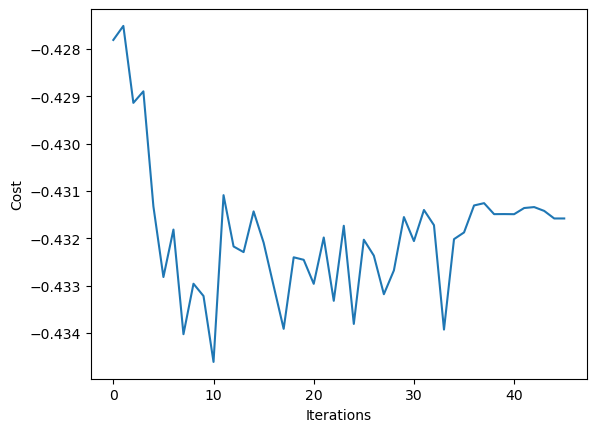

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 400
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 13, 22, 31])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4 13 22 31]
[ 4. 13. 22. 31.]
0.4261926614305381

[ 5. 13. 22. 31.]
0.42722952909159995

[ 5. 13. 22. 31.]urrent cost: -0.42722952909159995]
0.42722952909159995

[ 5. 14. 22. 31.]
0.4264824923490865

[ 5. 14. 22. 31.]urrent cost: -0.4264824923490865]
0.4264824923490865

[ 5. 13. 23. 31.]
0.4305641515740392

[ 5. 13. 23. 31.]urrent cost: -0.4305641515740392]
0.4305641515740392

[ 5. 13. 23. 32.]
0.43086260984098607

[ 5. 13. 23. 32.]urrent cost: -0.43086260984098607]
0.43086260984098607

[ 5.28933966 12.79153815 23.93053199 32.08328528]
0.4282691576621605

[ 5.28933966 12.79153815 23.93053199 32.08328528]]
0.4282691576621605

[ 4.50698124 12.98186753 23.0809397  32.00724433]
0.4280452547260005

[ 4.50698124 12.98186753 23.0809397  32.00724433]]
0.4280452547260005

[ 5.         13.2439533  23.05465149 32.        ]
0.42800583353476485

[ 5.         13.2439533  23.05465149 32.        ]5]
0.42800583353476485

[ 5.18966238 12.61250373 22.74751884 32.01131759]
0.4268562718397375

[ 5.189662

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4287098373264555
       x: [ 5.000e+00  1.300e+01  2.300e+01  3.200e+01]
    nfev: 40
   maxcv: 0.0

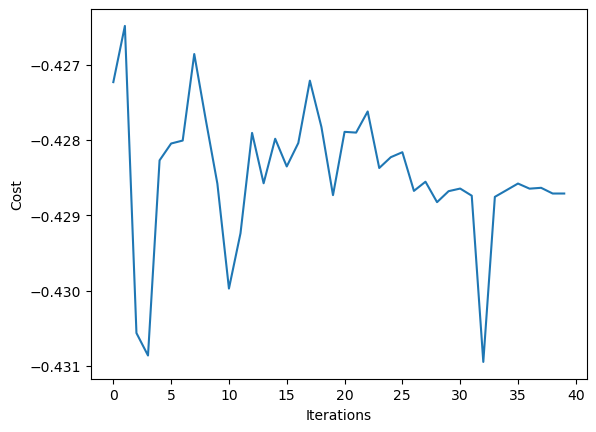

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.7394568036395673

[ 3.5  7.5 12.5 17.5]
0.7414477151606954

[ 3.5  7.5 12.5 17.5]nt cost: -0.7414477151606954]
0.7414477151606954

[ 3.5  8.5 12.5 17.5]
0.7414770757142144

[ 3.5  8.5 12.5 17.5]nt cost: -0.7414770757142144]
0.7414770757142144

[ 3.5  8.5 13.5 17.5]
0.7413725375523341

[ 3.5  8.5 13.5 17.5]nt cost: -0.7413725375523341]
0.7413725375523341

[ 3.5  8.5 12.5 18.5]
0.7414241487536715

[ 3.5  8.5 12.5 18.5]nt cost: -0.7414241487536715]
0.7414241487536715

[ 4.49816443  8.51472022 12.44758869 17.47346451]
0.742425075477628

[ 4.49816443  8.51472022 12.44758869 17.47346451]
0.742425075477628

[ 5.49004967  8.54562203 12.33756289 17.41775919]
0.7430432989297726

[ 5.49004967  8.54562203 12.33756289 17.41775919]]
0.7430432989297726

[ 6.06709034  8.9803549  11.82157514 16.95755484]
0.742723333064218

[ 6.06709034  8.9803549  11.82157514 16.95755484]
0.742723333064218

[ 5.50732494  8.53654085 12.67656448 17.05074828]
0.744349260529222

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7435862675779245
       x: [ 5.509e+00  8.533e+00  1.268e+01  1.705e+01]
    nfev: 47
   maxcv: 0.0

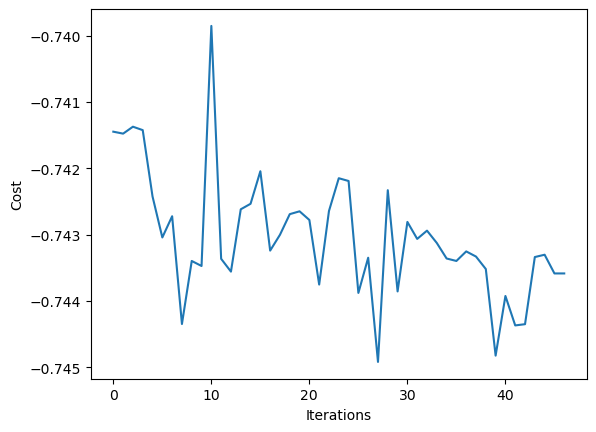

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.7404590479780019

[ 5.  8. 12. 16.]
0.7416495029410897

[ 5.  8. 12. 16.]urrent cost: -0.7416495029410897]
0.7416495029410897

[ 5.  9. 12. 16.]
0.741434180658963

[ 5.  9. 12. 16.]urrent cost: -0.741434180658963]
0.741434180658963

[ 5.  8. 13. 16.]
0.7424895319017566

[ 5.  8. 13. 16.]urrent cost: -0.7424895319017566]
0.7424895319017566

[ 5.  8. 13. 17.]
0.7435949540633343

[ 5.  8. 13. 17.]urrent cost: -0.7435949540633343]
0.7435949540633343

[ 5.64645641  7.88307288 13.4561635  17.60028079]
0.7430545744808392

[ 5.64645641  7.88307288 13.4561635  17.60028079]]
0.7430545744808392

[ 4.56436632  7.96239021 13.1467257  17.19308125]
0.7437749101309649

[ 4.56436632  7.96239021 13.1467257  17.19308125]]
0.7437749101309649

[ 4.50951057  7.57114984 12.86080079 17.30339338]
0.7454165276465936

[ 4.50951057  7.57114984 12.86080079 17.30339338]]
0.7454165276465936

[ 4.42838977  7.26693067 12.50829723 17.46652324]
0.7422176590926517

[ 4.42838977  7.266930

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7440945200991809
       x: [ 4.509e+00  7.571e+00  1.286e+01  1.730e+01]
    nfev: 42
   maxcv: 0.0

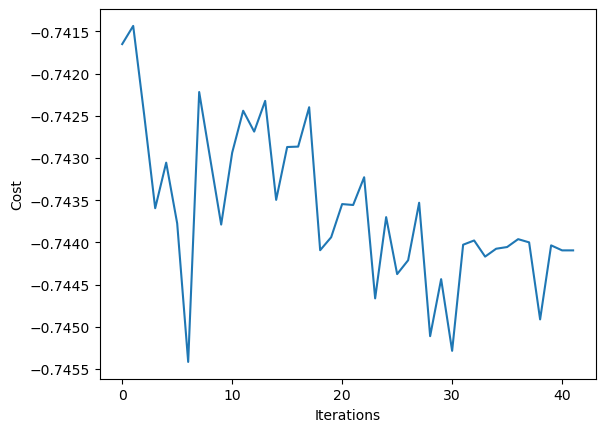

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Sequence Optimization

B=0.05

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.6761669016549343

[ 3.5  7.5 12.5 17.5]
0.6767459747348207

[ 3.5  7.5 12.5 17.5]nt cost: -0.6767459747348207]
0.6767459747348207

[ 3.5  8.5 12.5 17.5]
0.6763425396757529

[ 3.5  8.5 12.5 17.5]nt cost: -0.6763425396757529]
0.6763425396757529

[ 3.5  7.5 13.5 17.5]
0.67737916148403

[ 3.5  7.5 13.5 17.5]nt cost: -0.67737916148403]
0.67737916148403

[ 3.5  7.5 13.5 18.5]
0.6771482452729268

[ 3.5  7.5 13.5 18.5]nt cost: -0.6771482452729268]
0.6771482452729268

[ 4.0933882   7.08659172 14.1488396  17.26337537]
0.6779896463927202

[ 4.0933882   7.08659172 14.1488396  17.26337537]]
0.6779896463927202

[ 4.04672095  6.57354732 14.95405697 16.96972149]
0.6815749791405575

[ 4.04672095  6.57354732 14.95405697 16.96972149]]
0.6815749791405575

[ 3.50306328  5.74039653 15.04938525 16.93495632]
0.6796552314573331

[ 3.50306328  5.74039653 15.04938525 16.93495632]]
0.6796552314573331

[ 4.04672095  6.57354732 15.12536512 17.4394592 ]
0.678641512256432

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.681662521083845
       x: [ 4.047e+00  6.575e+00  1.495e+01  1.697e+01]
    nfev: 48
   maxcv: 0.0

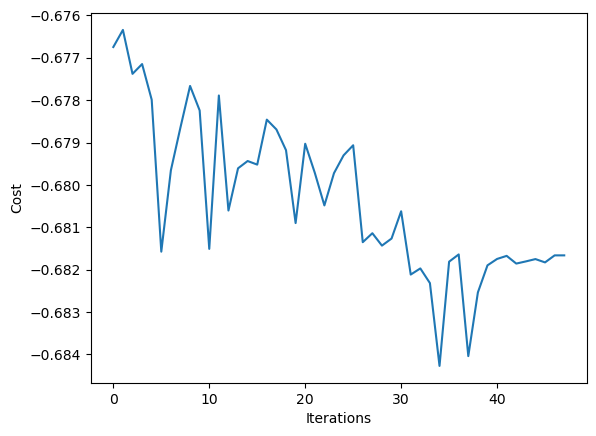

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.6764831019837306

[ 5.  8. 12. 16.]
0.677680438200853

[ 5.  8. 12. 16.]urrent cost: -0.677680438200853]
0.677680438200853

[ 5.  9. 12. 16.]
0.6770726912119199

[ 5.  9. 12. 16.]urrent cost: -0.6770726912119199]
0.6770726912119199

[ 5.  8. 13. 16.]
0.6790423555923989

[ 5.  8. 13. 16.]urrent cost: -0.6790423555923989]
0.6790423555923989

[ 5.  8. 13. 17.]
0.6785702704177047

[ 5.  8. 13. 17.]urrent cost: -0.6785702704177047]
0.6785702704177047

[ 5.60780416  7.6914892  13.69135055 15.76035525]
0.6792884370340586

[ 5.60780416  7.6914892  13.69135055 15.76035525]]
0.6792884370340586

[ 4.8844329   7.42323881 14.29248044 15.55198395]
0.678957695831612

[ 4.8844329   7.42323881 14.29248044 15.55198395]
0.678957695831612

[ 5.5402158   8.16740243 13.7886604  15.66304541]
0.6770531640602606

[ 5.5402158   8.16740243 13.7886604  15.66304541]]
0.6770531640602606

[ 5.93851111  6.77946475 13.64577282 15.99861346]
0.6750015439868333

[ 5.93851111  6.77946475 

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6823622399594185
       x: [ 5.668e+00  7.646e+00  1.368e+01  1.552e+01]
    nfev: 45
   maxcv: 0.0

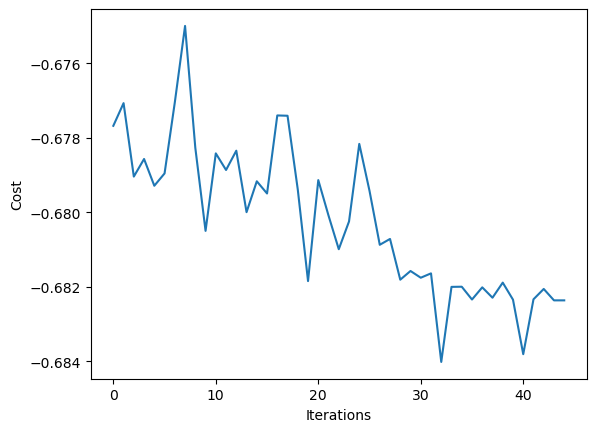

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 400
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 5. 15. 25. 35.]
[ 5. 15. 25. 35.]
0.5008811096961293

[ 6. 15. 25. 35.]
0.5010190761842074

[ 6. 15. 25. 35.]urrent cost: -0.5010190761842074]
0.5010190761842074

[ 6. 16. 25. 35.]
0.5008528624877758

[ 6. 16. 25. 35.]urrent cost: -0.5008528624877758]
0.5008528624877758

[ 6. 15. 26. 35.]
0.5016330893628249

[ 6. 15. 26. 35.]urrent cost: -0.5016330893628249]
0.5016330893628249

[ 6. 15. 26. 36.]
0.5021586487978996

[ 6. 15. 26. 36.]urrent cost: -0.5021586487978996]
0.5021586487978996

[ 6.16491485 14.80132055 26.73394554 36.62821454]
0.5035087551782229

[ 6.16491485 14.80132055 26.73394554 36.62821454]]
0.5035087551782229

[ 5.70363365 15.25216608 27.47303868 36.82237761]
0.5036370815634196

[ 5.70363365 15.25216608 27.47303868 36.82237761]]
0.5036370815634196

[ 5.3437457  14.90530746 27.46000935 36.82237761]
0.5041226036938707

[ 5.3437457  14.90530746 27.46000935 36.82237761]]
0.5041226036938707

[ 5.37096549 14.10334773 27.9853461  37.10546943]
0.5046648662201282

[ 5.37096549 14

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5051113815492592
       x: [ 5.143e+00  1.386e+01  2.781e+01  3.804e+01]
    nfev: 51
   maxcv: 0.0

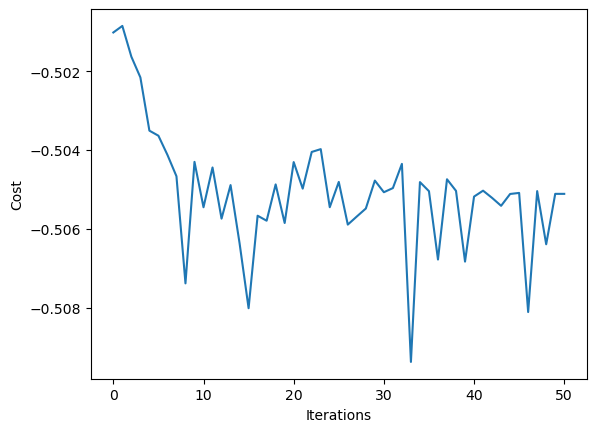

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 400
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 13, 22, 31])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4 13 22 31]
[ 4. 13. 22. 31.]
0.5043792816527477

[ 5. 13. 22. 31.]
0.5007149466748422

[ 5. 13. 22. 31.]urrent cost: -0.5007149466748422]
0.5007149466748422

[ 4. 14. 22. 31.]
0.5021329086065519

[ 4. 14. 22. 31.]urrent cost: -0.5021329086065519]
0.5021329086065519

[ 4. 13. 23. 31.]
0.5026968555690053

[ 4. 13. 23. 31.]urrent cost: -0.5026968555690053]
0.5026968555690053

[ 4. 13. 22. 32.]
0.5052728517770577

[ 4. 13. 22. 32.]urrent cost: -0.5052728517770577]
0.5052728517770577

[ 3.22057595 12.52218419 21.64213879 32.19006724]
0.5003087249028388

[ 3.22057595 12.52218419 21.64213879 32.19006724]]
0.5003087249028388

[ 4.47379832 12.87817377 21.90875797 32.04846046]
0.5010216378526736

[ 4.47379832 12.87817377 21.90875797 32.04846046]]
0.5010216378526736

[ 4.         13.14986578 21.79989941 32.        ]
0.5020377135337352

[ 4.         13.14986578 21.79989941 32.        ]]
0.5020377135337352

[ 3.88834737 13.09470159 22.4775565  32.02247414]
0.5011478786934263

[ 3.88834737 13.094

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5017043035499199
       x: [ 4.000e+00  1.300e+01  2.200e+01  3.200e+01]
    nfev: 40
   maxcv: 0.0

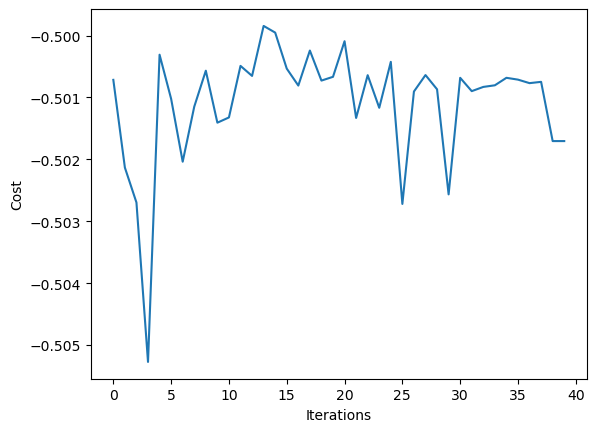

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.2235705331470543

[ 3.5  7.5 12.5 17.5]
0.22863392104983143

[ 3.5  7.5 12.5 17.5]nt cost: -0.22863392104983143]
0.22863392104983143

[ 3.5  8.5 12.5 17.5]
0.2269342320869845

[ 3.5  8.5 12.5 17.5]nt cost: -0.2269342320869845]
0.2269342320869845

[ 3.5  7.5 13.5 17.5]
0.23182031569320383

[ 3.5  7.5 13.5 17.5]nt cost: -0.23182031569320383]
0.23182031569320383

[ 3.5  7.5 13.5 18.5]
0.22890346944919332

[ 3.5  7.5 13.5 18.5]nt cost: -0.22890346944919332]
0.22890346944919332

[ 4.23709876  7.2525691  13.96385692 17.07538238]
0.23624099130113768

[ 4.23709876  7.2525691  13.96385692 17.07538238]8]
0.23624099130113768

[ 4.58831428  6.90975561 14.60652689 16.48707813]
0.23741809423381524

[ 4.58831428  6.90975561 14.60652689 16.48707813]4]
0.23741809423381524

[ 5.27723846  6.7511822  14.90380333 17.12884496]
0.2350441261493805

[ 5.27723846  6.7511822  14.90380333 17.12884496]]
0.2350441261493805

[ 4.58831428  7.35091607 14.84185103 16.487078

[ 4.72849903  8.40135644 15.02325845 15.52608537]74]
0.24490399850705574

[ 4.72851463  8.40141573 15.02335356 15.52614931]
0.24491431497062346

[ 4.72851463  8.40141573 15.02335356 15.52614931]46]
0.24491431497062346

[ 4.72851463  8.40141573 15.02335356 15.52614931]
0.24491431497062346



In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.24491431497062346
       x: [ 4.729e+00  8.401e+00  1.502e+01  1.553e+01]
    nfev: 60
   maxcv: 0.0

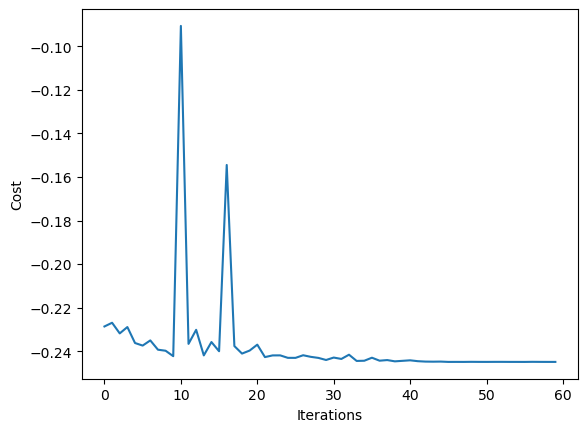

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.2304605058728664

[ 5.  8. 12. 16.]
0.2339438745457754

[ 5.  8. 12. 16.]urrent cost: -0.2339438745457754]
0.2339438745457754

[ 5.  9. 12. 16.]
0.23297990283460596

[ 5.  9. 12. 16.]urrent cost: -0.23297990283460596]
0.23297990283460596

[ 5.  8. 13. 16.]
0.2366912402995083

[ 5.  8. 13. 16.]urrent cost: -0.2366912402995083]
0.2366912402995083

[ 5.  8. 13. 17.]
0.23544794436002048

[ 5.  8. 13. 17.]urrent cost: -0.23544794436002048]
0.23544794436002048

[ 5.7400225   7.79520952 13.58366273 15.73586862]
0.2390638655098502

[ 5.7400225   7.79520952 13.58366273 15.73586862]]
0.2390638655098502

[ 5.84330833  7.492354   14.44681552 15.3452565 ]
0.23448498158241682

[ 5.84330833  7.492354   14.44681552 15.3452565 ]2]
0.23448498158241682

[ 5.56121868  8.23030757 13.7034936  15.61603775]
0.2394002519514398

[ 5.56121868  8.23030757 13.7034936  15.61603775]]
0.2394002519514398

[ 6.40534335  8.70960469 13.57883619 15.82143577]
0.24042926968746445

[ 6.40534

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.24248166464589865
       x: [ 6.511e+00  9.048e+00  1.408e+01  1.560e+01]
    nfev: 54
   maxcv: 0.0

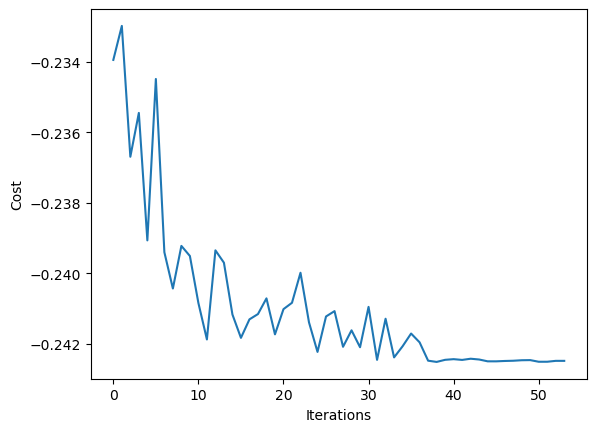

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.1694675921629949

[ 3.5  7.5 12.5 17.5]
0.17487672442246793

[ 3.5  7.5 12.5 17.5]nt cost: -0.17487672442246793]
0.17487672442246793

[ 3.5  8.5 12.5 17.5]
0.17472982926485917

[ 3.5  8.5 12.5 17.5]nt cost: -0.17472982926485917]
0.17472982926485917

[ 3.5  7.5 13.5 17.5]
0.17611454231631726

[ 3.5  7.5 13.5 17.5]nt cost: -0.17611454231631726]
0.17611454231631726

[ 3.5  7.5 13.5 18.5]
0.1751152918430882

[ 3.5  7.5 13.5 18.5]nt cost: -0.1751152918430882]
0.1751152918430882

[ 4.45904513  7.47395533 13.71946648 17.32283179]
0.1789365206953466

[ 4.45904513  7.47395533 13.71946648 17.32283179]]
0.1789365206953466

[ 5.29878074  7.42402779 14.14018287 16.98320101]
0.17710440732254662

[ 5.29878074  7.42402779 14.14018287 16.98320101]2]
0.17710440732254662

[ 4.87891294  7.44899156 13.92982468 17.1530164 ]
0.17820772077538305

[ 4.87891294  7.44899156 13.92982468 17.1530164 ]5]
0.17820772077538305

[ 4.45225841  7.22404746 13.71946648 17.322831

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.1818973870964571
       x: [ 4.849e+00  7.764e+00  1.405e+01  1.731e+01]
    nfev: 57
   maxcv: 0.0

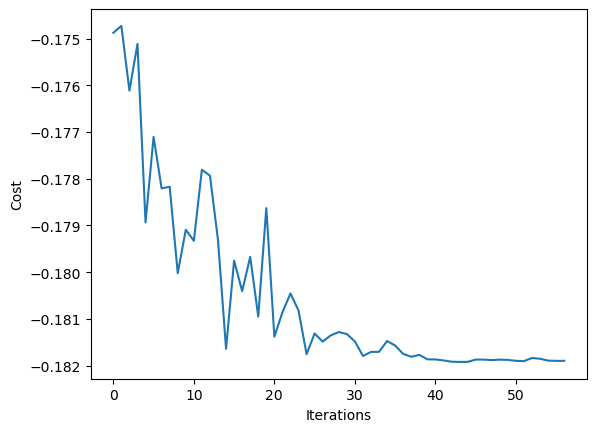

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.17256596436780483

[ 5.  8. 12. 16.]
0.1748925447984698

[ 5.  8. 12. 16.]urrent cost: -0.1748925447984698]
0.1748925447984698

[ 5.  9. 12. 16.]
0.17479631330033024

[ 5.  9. 12. 16.]urrent cost: -0.17479631330033024]
0.17479631330033024

[ 5.  8. 13. 16.]
0.17483569346935293

[ 5.  8. 13. 16.]urrent cost: -0.17483569346935293]
0.17483569346935293

[ 5.  8. 12. 17.]
0.1770414658353576

[ 5.  8. 12. 17.]urrent cost: -0.1770414658353576]
0.1770414658353576

[ 5.73414051  7.96963464 11.98206085 17.678081  ]
0.17980150253112298

[ 5.73414051  7.96963464 11.98206085 17.678081  ]8]
0.17980150253112298

[ 6.36926132  7.93509168 11.96165368 18.44945114]
0.1736035088692663

[ 6.36926132  7.93509168 11.96165368 18.44945114]]
0.1736035088692663

[ 5.71347729  7.4700618  11.98206085 17.678081  ]
0.17590633582848564

[ 5.71347729  7.4700618  11.98206085 17.678081  ]4]
0.17590633582848564

[ 5.98702815  8.90158801 11.9751893  17.93781848]
0.1806068917501813

[ 5.98

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.1831050252107399
       x: [ 6.344e+00  8.882e+00  1.198e+01  1.829e+01]
    nfev: 55
   maxcv: 0.0

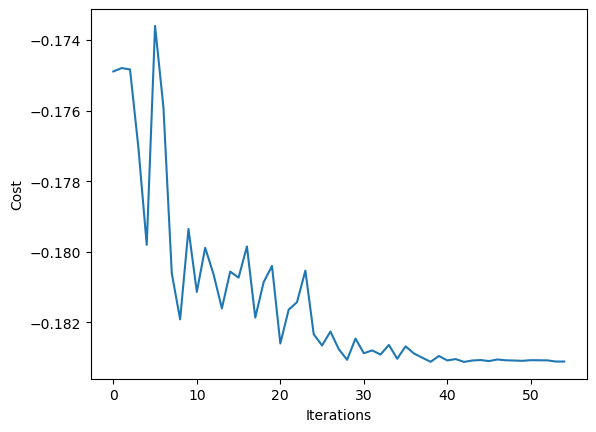

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Sequence Optimization

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.8461193184217569

[2.25 3.75 6.25 8.75]
0.8479420463595494

[2.25 3.75 6.25 8.75]nt cost: -0.8479420463595494]
0.8479420463595494

[2.25 4.75 6.25 8.75]
0.8475202337411939

[2.25 4.75 6.25 8.75]nt cost: -0.8475202337411939]
0.8475202337411939

[2.25 3.75 7.25 8.75]
0.8488266046106903

[2.25 3.75 7.25 8.75]nt cost: -0.8488266046106903]
0.8488266046106903

[2.25 3.75 7.25 9.75]
0.8443607538622572

[2.25 3.75 7.25 9.75]nt cost: -0.8443607538622572]
0.8443607538622572

[2.62031922 3.66430135 7.42971356 7.84268393]
0.6282302415175782

[2.62031922 3.66430135 7.42971356 7.84268393]5782]
0.6282302415175782

[1.75001418 3.74965265 7.25072842 8.74632246]
0.8482852166331891

[1.75001418 3.74965265 7.25072842 8.74632246]1891]
0.8482852166331891

[2.25017368 3.50000006 7.25       8.75      ]
0.848571293964876

[2.25017368 3.50000006 7.25       8.75      ]876]
0.848571293964876

[2.36633295 3.85651396 7.34218798 8.28457246]
0.8473814653796786

[2.3663329

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8504595008808409
       x: [ 2.528e+00  3.808e+00  7.523e+00  8.773e+00]
    nfev: 47
   maxcv: 0.0

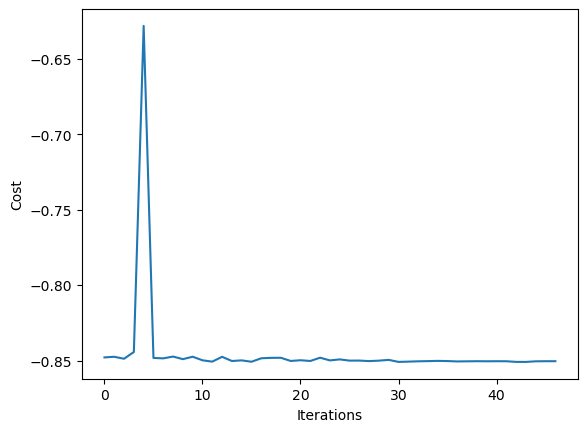

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.8508623475748047

[5.  5.5 7.  8.5]
0.8227930718334828

[5.  5.5 7.  8.5]urrent cost: -0.8227930718334828]
0.8227930718334828

[4.  6.5 7.  8.5]
0.8403423896590752

[4.  6.5 7.  8.5]urrent cost: -0.8403423896590752]
0.8403423896590752

[4.  5.5 8.  8.5]
0.7559985222828489

[4.  5.5 8.  8.5]urrent cost: -0.7559985222828489]
0.7559985222828489

[4.  5.5 7.  9.5]
0.8480924919630759

[4.  5.5 7.  9.5]urrent cost: -0.8480924919630759]
0.8480924919630759

[3.71796966 5.39429911 6.04684121 8.47216945]
0.8441446520127842

[3.71796966 5.39429911 6.04684121 8.47216945]7842]
0.8441446520127842

[3.85898483 5.44714956 6.52342061 8.48608473]
0.8485139997551834

[3.85898483 5.44714956 6.52342061 8.48608473]1834]
0.8485139997551834

[4.24076428 5.49258266 6.93311404 8.49804705]
0.8520558919568877

[4.24076428 5.49258266 6.93311404 8.49804705]8877]
0.8520558919568877

[4.24076428 5.36834425 6.9468915  8.49804705]
0.8515699009406492

[4.24076428 5.36834425 6.946891

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8524783433110804
       x: [ 4.241e+00  5.493e+00  6.932e+00  8.498e+00]
    nfev: 46
   maxcv: 0.0

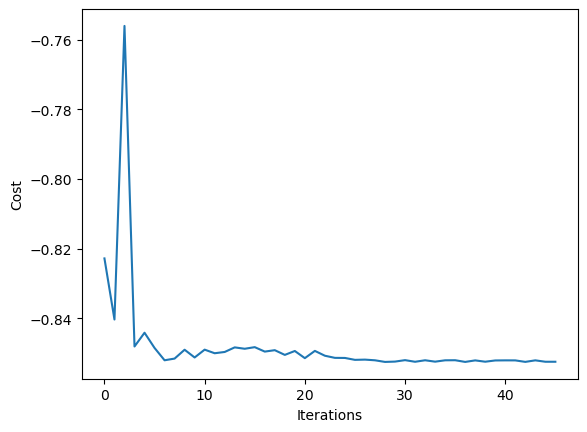

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 500
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 6.25 18.75 31.25 43.75]
[ 6.25 18.75 31.25 43.75]
0.41463604192404474

[ 7.25 18.75 31.25 43.75]
0.41414315985272826

[ 7.25 18.75 31.25 43.75]ost: -0.41414315985272826]
0.41414315985272826

[ 6.25 19.75 31.25 43.75]
0.4143965251595668

[ 6.25 19.75 31.25 43.75]ost: -0.4143965251595668]
0.4143965251595668

[ 6.25 18.75 32.25 43.75]
0.4154315135040432

[ 6.25 18.75 32.25 43.75]ost: -0.4154315135040432]
0.4154315135040432

[ 6.25 18.75 32.25 44.75]
0.4148642438779352

[ 6.25 18.75 32.25 44.75]ost: -0.4148642438779352]
0.4148642438779352

[ 5.8100093  18.53618587 32.96010921 43.2436043 ]
0.4156094773747984

[ 5.8100093  18.53618587 32.96010921 43.2436043 ]]
0.4156094773747984

[ 6.66364711 18.41216756 33.37199287 42.9498803 ]
0.41439281133235173

[ 6.66364711 18.41216756 33.37199287 42.9498803 ]3]
0.41439281133235173

[ 5.83779894 19.02972722 33.01323488 43.19047864]
0.4135862299384051

[ 5.83779894 19.02972722 33.01323488 43.19047864]]
0.4135862299384051

[ 5.41038748 17.62723213 32.90

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4160760975160528
       x: [ 5.792e+00  1.856e+01  3.297e+01  4.323e+01]
    nfev: 48
   maxcv: 0.0

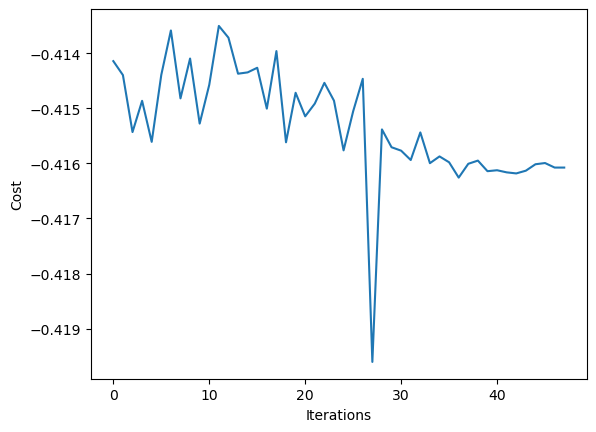

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 500
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 15.5, 27, 38.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4.  15.5 27.  38.5]
[ 4.  15.5 27.  38.5]
0.4155484313376564

[ 5.  15.5 27.  38.5]
0.4135418199698995

[ 5.  15.5 27.  38.5]nt cost: -0.4135418199698995]
0.4135418199698995

[ 4.  16.5 27.  38.5]
0.4157465161633112

[ 4.  16.5 27.  38.5]nt cost: -0.4157465161633112]
0.4157465161633112

[ 4.  16.5 28.  38.5]
0.4161697400727478

[ 4.  16.5 28.  38.5]nt cost: -0.4161697400727478]
0.4161697400727478

[ 4.  16.5 28.  39.5]
0.41539218458280186

[ 4.  16.5 28.  39.5]nt cost: -0.41539218458280186]
0.41539218458280186

[ 3.0887919  16.5899509  28.19218722 38.14690977]
0.41252997654691104

[ 3.0887919  16.5899509  28.19218722 38.14690977]4]
0.41252997654691104

[ 4.48972095 16.52202408 28.04705619 38.41354742]
0.4146621054390946

[ 4.48972095 16.52202408 28.04705619 38.41354742]]
0.4146621054390946

[ 3.98876817 16.74974756 28.         38.5       ]
0.4141467499825514

[ 3.98876817 16.74974756 28.         38.5       ]]
0.4141467499825514

[ 3.83537016 16.03058821 28.02413944 38.45565054]
0.412

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.41394446695460496
       x: [ 4.000e+00  1.650e+01  2.800e+01  3.850e+01]
    nfev: 40
   maxcv: 0.0

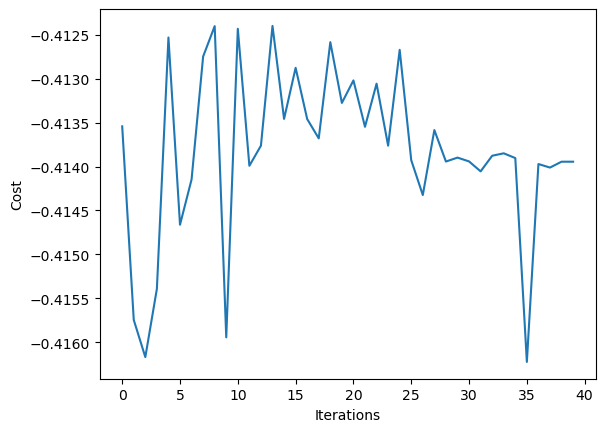

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.5732000798223357

[2.25 3.75 6.25 8.75]
0.5901605509556331

[2.25 3.75 6.25 8.75]nt cost: -0.5901605509556331]
0.5901605509556331

[2.25 4.75 6.25 8.75]
0.5886110139698724

[2.25 4.75 6.25 8.75]nt cost: -0.5886110139698724]
0.5886110139698724

[2.25 3.75 7.25 8.75]
0.5902815197133114

[2.25 3.75 7.25 8.75]nt cost: -0.5902815197133114]
0.5902815197133114

[2.25 3.75 7.25 9.75]
0.5624942368117333

[2.25 3.75 7.25 9.75]nt cost: -0.5624942368117333]
0.5624942368117333

[2.77039541 3.70245581 7.25371166 7.89740726]
0.5671207076349516

[2.77039541 3.70245581 7.25371166 7.89740726]9516]
0.5671207076349516

[1.77223704 3.7417902  7.25064092 8.60277657]
0.5860250833351295

[1.77223704 3.7417902  7.25064092 8.60277657]1295]
0.5860250833351295

[2.25429533 3.5000369  7.25       8.75      ]
0.5866062134562771

[2.25429533 3.5000369  7.25       8.75      ]2771]
0.5866062134562771

[2.48932156 3.95852727 7.25168178 8.3636857 ]
0.5886286368239846

[2.4893

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6005501798615517
       x: [ 2.741e+00  4.413e+00  7.211e+00  8.886e+00]
    nfev: 56
   maxcv: 0.0

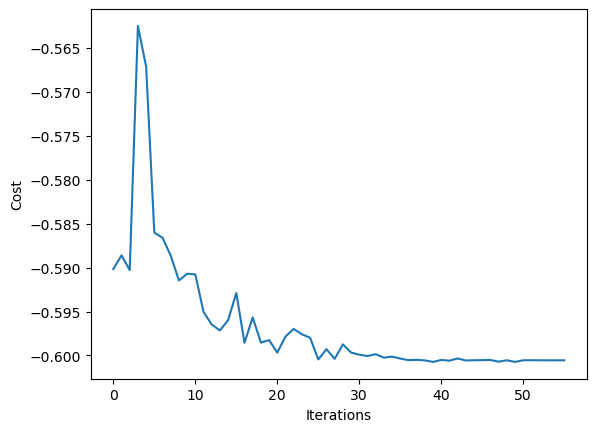

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.6042610943699251

[5.  5.5 7.  8.5]
0.5601090379059487

[5.  5.5 7.  8.5]urrent cost: -0.5601090379059487]
0.5601090379059487

[4.  6.5 7.  8.5]
0.5612133194859916

[4.  6.5 7.  8.5]urrent cost: -0.5612133194859916]
0.5612133194859916

[4.  5.5 8.  8.5]
0.5417137736493293

[4.  5.5 8.  8.5]urrent cost: -0.5417137736493293]
0.5417137736493293

[4.  5.5 7.  9.5]
0.5848030001434079

[4.  5.5 7.  9.5]urrent cost: -0.5848030001434079]
0.5848030001434079

[3.50921857 5.02149344 6.30474216 8.28370948]
0.5987482294361649

[3.50921857 5.02149344 6.30474216 8.28370948]1649]
0.5987482294361649

[3.75460928 5.26074672 6.65237108 8.39185474]
0.6027158820467673

[3.75460928 5.26074672 6.65237108 8.39185474]7673]
0.6027158820467673

[4.2200775  5.43486529 6.90536093 8.47055836]
0.5996841981800327

[4.2200775  5.43486529 6.90536093 8.47055836]0327]
0.5996841981800327

[4.         5.6029695  6.92913193 8.5       ]
0.6038901177619547

[4.         5.6029695  6.929131

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6053491923585383
       x: [ 4.040e+00  5.502e+00  7.015e+00  8.492e+00]
    nfev: 54
   maxcv: 0.0

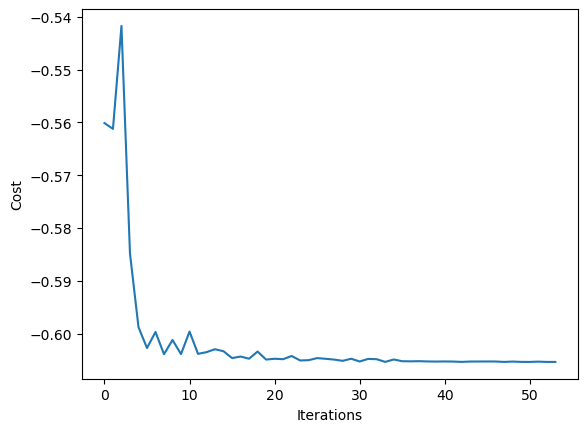

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 100
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.5898671550414152

[2.25 3.75 6.25 8.75]
0.610728529909005

[2.25 3.75 6.25 8.75]nt cost: -0.610728529909005]
0.610728529909005

[2.25 4.75 6.25 8.75]
0.6136741945199186

[2.25 4.75 6.25 8.75]nt cost: -0.6136741945199186]
0.6136741945199186

[2.25 4.75 7.25 8.75]
0.607551448311332

[2.25 4.75 7.25 8.75]nt cost: -0.607551448311332]
0.607551448311332

[2.25 4.75 6.25 9.75]
0.5165058405721389

[2.25 4.75 6.25 9.75]nt cost: -0.5165058405721389]
0.5165058405721389

[2.45942104 4.77957064 6.1885356  7.77455624]
0.600650290340891

[2.45942104 4.77957064 6.1885356  7.77455624]891]
0.600650290340891

[2.35471052 4.76478532 6.2192678  8.26227812]
0.6167305891913634

[2.35471052 4.76478532 6.2192678  8.26227812]3634]
0.6167305891913634

[2.59914071 4.76478532 6.2192678  8.31475559]
0.6247126655516435

[2.59914071 4.76478532 6.2192678  8.31475559]6435]
0.6247126655516435

[3.08819692 4.80924048 6.126865   8.33234777]
0.624375986122756

[3.08819692 4.809

[2.73419393 4.70268088 6.51942719 8.66890423]
0.6389564853890225

[2.73419393 4.70268088 6.51942719 8.66890423]90225]
0.6389564853890225

[2.73422852 4.70272577 6.51935511 8.66883636]
0.6389103608828632

[2.73422852 4.70272577 6.51935511 8.66883636]28632]
0.6389103608828632

[2.7340748  4.70269602 6.51940498 8.66891083]
0.6389974709183216

[2.7340748  4.70269602 6.51940498 8.66891083]83216]
0.6389974709183216

[2.73400767 4.70269089 6.51947795 8.66889888]
0.6389906727202573

[2.73400767 4.70269089 6.51947795 8.66889888]02573]
0.6389906727202573

[2.73401261 4.702707   6.51932746 8.66891125]
0.6389901746041622

[2.73401261 4.702707   6.51932746 8.66891125]41622]
0.6389901746041622

[2.73401261 4.702707   6.51932746 8.66891125]
0.6389901746041622



In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6389901746041622
       x: [ 2.734e+00  4.703e+00  6.519e+00  8.669e+00]
    nfev: 66
   maxcv: 0.0

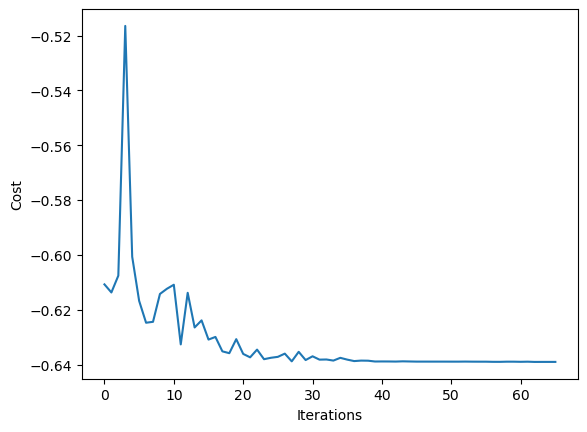

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 100
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.6159416721860969

[5.  5.5 7.  8.5]
0.52033207599961

[5.  5.5 7.  8.5]urrent cost: -0.52033207599961]
0.52033207599961

[4.  6.5 7.  8.5]
0.5438082005771163

[4.  6.5 7.  8.5]urrent cost: -0.5438082005771163]
0.5438082005771163

[4.  5.5 8.  8.5]
0.4805429224551762

[4.  5.5 8.  8.5]urrent cost: -0.4805429224551762]
0.4805429224551762

[4.  5.5 7.  9.5]
0.5861527869535363

[4.  5.5 7.  9.5]urrent cost: -0.5861527869535363]
0.5861527869535363

[3.47813215 5.10627237 6.26095019 8.33740271]
0.6177311456230724

[3.47813215 5.10627237 6.26095019 8.33740271]0724]
0.6177311456230724

[3.18905961 4.88817914 6.59375729 8.24733697]
0.6222111379777012

[3.18905961 4.88817914 6.59375729 8.24733697]7012]
0.6222111379777012

[3.33962847 4.68860705 6.59375729 8.24733697]
0.6088622158520001

[3.33962847 4.68860705 6.59375729 8.24733697]0001]
0.6088622158520001

[2.92268621 5.23254916 6.63208224 8.00446725]
0.6024999785158233

[2.92268621 5.23254916 6.63208224 8.0

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6405399740927956
       x: [ 2.925e+00  4.903e+00  6.712e+00  8.785e+00]
    nfev: 55
   maxcv: 0.0

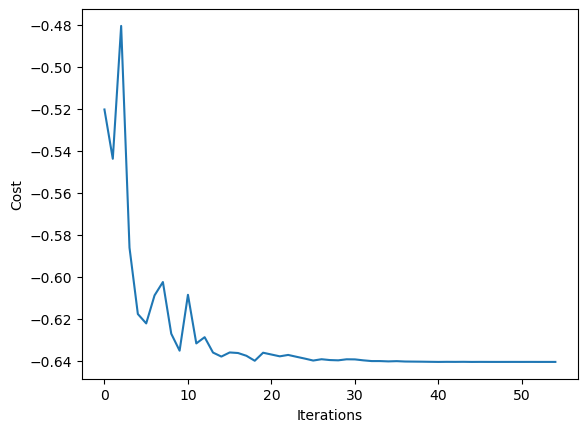

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Sequence Optimization

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 300
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 3.75 11.25 18.75 26.25]
[ 3.75 11.25 18.75 26.25]
0.5368429870729445

[ 4.75 11.25 18.75 26.25]
0.5383344814673708

[ 4.75 11.25 18.75 26.25]ost: -0.5383344814673708]
0.5383344814673708

[ 4.75 12.25 18.75 26.25]
0.5378477645472612

[ 4.75 12.25 18.75 26.25]ost: -0.5378477645472612]
0.5378477645472612

[ 4.75 11.25 19.75 26.25]
0.5394377140121693

[ 4.75 11.25 19.75 26.25]ost: -0.5394377140121693]
0.5394377140121693

[ 4.75 11.25 19.75 27.25]
0.5389206971120383

[ 4.75 11.25 19.75 27.25]ost: -0.5389206971120383]
0.5389206971120383

[ 5.5008442  11.00497824 20.30538644 25.98972471]
0.5416522015254785

[ 5.5008442  11.00497824 20.30538644 25.98972471]]
0.5416522015254785

[ 6.30821673 10.78608702 20.80154326 25.75720667]
0.5413143155192591

[ 6.30821673 10.78608702 20.80154326 25.75720667]]
0.5413143155192591

[ 5.3851137  10.51920038 20.2876901  26.00742105]
0.5421225971471783

[ 5.3851137  10.51920038 20.2876901  26.00742105]]
0.5421225971471783

[ 4.76893857 10.44208262 20.89475604 

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.540908152100167
       x: [ 5.360e+00  1.051e+01  2.033e+01  2.596e+01]
    nfev: 49
   maxcv: 0.0

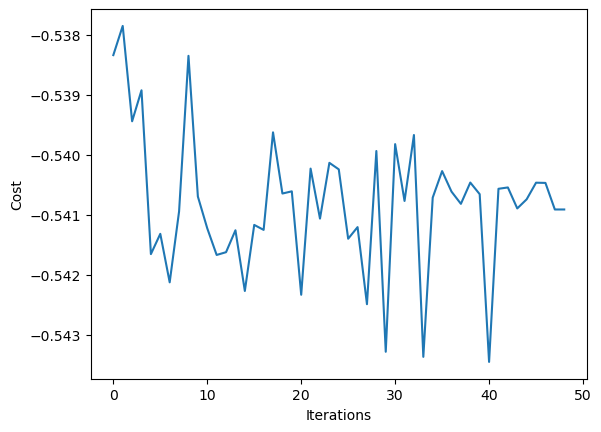

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 300
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 10.5, 17, 23.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4.  10.5 17.  23.5]
[ 4.  10.5 17.  23.5]
0.5363601790476265

[ 5.  10.5 17.  23.5]
0.5375448947162035

[ 5.  10.5 17.  23.5]nt cost: -0.5375448947162035]
0.5375448947162035

[ 5.  11.5 17.  23.5]
0.5374497976568036

[ 5.  11.5 17.  23.5]nt cost: -0.5374497976568036]
0.5374497976568036

[ 5.  10.5 18.  23.5]
0.5388863313906349

[ 5.  10.5 18.  23.5]nt cost: -0.5388863313906349]
0.5388863313906349

[ 5.  10.5 18.  24.5]
0.5386834723888213

[ 5.  10.5 18.  24.5]nt cost: -0.5386834723888213]
0.5386834723888213

[ 5.65683885 10.44727558 18.74372927 23.38752941]
0.5399146785695406

[ 5.65683885 10.44727558 18.74372927 23.38752941]]
0.5399146785695406

[ 5.66003128 10.37735253 19.73006206 23.23837106]
0.5419934664931434

[ 5.66003128 10.37735253 19.73006206 23.23837106]]
0.5419934664931434

[ 5.3158767  10.66648745 20.61931837 23.15362538]
0.5429349545846632

[ 5.3158767  10.66648745 20.61931837 23.15362538]]
0.5429349545846632

[ 5.10906334  9.80502395 21.08031227 23.10269902]
0.543424314

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5438878325375356
       x: [ 5.108e+00  9.804e+00  2.108e+01  2.310e+01]
    nfev: 53
   maxcv: 0.0

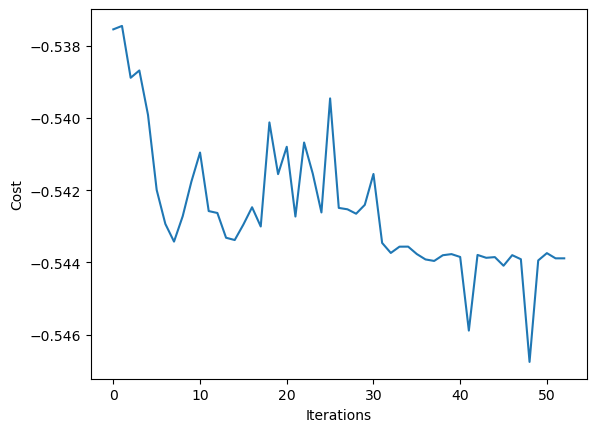

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 300
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 3.75 11.25 18.75 26.25]
[ 3.75 11.25 18.75 26.25]
0.6080016907398377

[ 4.75 11.25 18.75 26.25]
0.6085031951339711

[ 4.75 11.25 18.75 26.25]ost: -0.6085031951339711]
0.6085031951339711

[ 4.75 12.25 18.75 26.25]
0.60829930232939

[ 4.75 12.25 18.75 26.25]ost: -0.60829930232939]
0.60829930232939

[ 4.75 11.25 19.75 26.25]
0.6090255875863112

[ 4.75 11.25 19.75 26.25]ost: -0.6090255875863112]
0.6090255875863112

[ 4.75 11.25 19.75 27.25]
0.6099314645250994

[ 4.75 11.25 19.75 27.25]ost: -0.6099314645250994]
0.6099314645250994

[ 5.17589384 11.0768476  20.19363266 28.01930016]
0.6129503571476224

[ 5.17589384 11.0768476  20.19363266 28.01930016]]
0.6129503571476224

[ 6.15237255 11.03558415 20.29935348 28.20262986]
0.6135576849425763

[ 6.15237255 11.03558415 20.29935348 28.20262986]]
0.6135576849425763

[ 6.1420672  10.03918157 20.34137491 28.27549892]
0.6124243363354854

[ 6.1420672  10.03918157 20.34137491 28.27549892]]
0.6124243363354854

[ 6.15237255 11.03558415 20.73249363 27.952

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6134499219398009
       x: [ 6.150e+00  1.103e+01  2.030e+01  2.820e+01]
    nfev: 44
   maxcv: 0.0

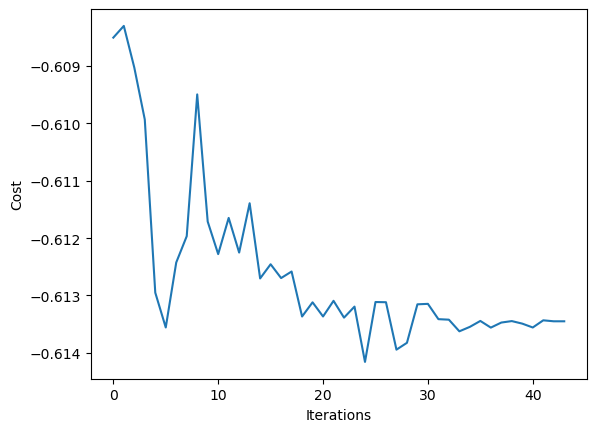

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 300
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 10.5, 17, 23.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4.  10.5 17.  23.5]
[ 4.  10.5 17.  23.5]
0.6086381750482379

[ 5.  10.5 17.  23.5]
0.6095707580349495

[ 5.  10.5 17.  23.5]nt cost: -0.6095707580349495]
0.6095707580349495

[ 5.  11.5 17.  23.5]
0.6078191746223152

[ 5.  11.5 17.  23.5]nt cost: -0.6078191746223152]
0.6078191746223152

[ 5.  10.5 18.  23.5]
0.6081351703296493

[ 5.  10.5 18.  23.5]nt cost: -0.6081351703296493]
0.6081351703296493

[ 5.  10.5 17.  24.5]
0.609620022204996

[ 5.  10.5 17.  24.5]nt cost: -0.609620022204996]
0.609620022204996

[ 5.38069069  9.78498428 16.41397722 24.52011018]
0.6080052896357465

[ 5.38069069  9.78498428 16.41397722 24.52011018]]
0.6080052896357465

[ 4.51298747 10.41245382 16.92824765 24.50246228]
0.607544429846842

[ 4.51298747 10.41245382 16.92824765 24.50246228]
0.607544429846842

[ 5.         10.65847298 16.80664459 24.5       ]
0.607745041076248

[ 5.         10.65847298 16.80664459 24.5       ]
0.607745041076248

[ 5.19814743 10.37152973 17.44070999 24.50277387]
0.6077391709206157



In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6074491225218638
       x: [ 5.000e+00  1.050e+01  1.700e+01  2.450e+01]
    nfev: 41
   maxcv: 0.0

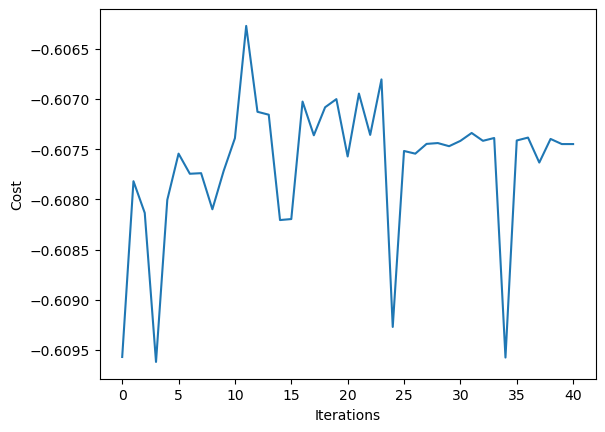

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()